<a href="https://colab.research.google.com/github/ulle9/DL-School/blob/master/NST_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Решите свою задачу

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

# Neural Style Transfer

In [0]:
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary

import copy
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check GPU availibility and choose device
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'cuda'
    !nvidia-smi

CUDA is available!  Training on GPU ...
Wed Jun 10 21:52:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

In [64]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [66]:
# Listing of available content and style files
DIR = Path(r'/content/drive/My Drive/Colab Notebooks/NST/')
for i in DIR.glob('*.*'):
  image = Image.open(i)
  tm = transforms.Compose([transforms.ToTensor()])
  print("{} image size:".format(i.stem), tuple(tm(image).size()))

picasso image size: (3, 1025, 800)
content image size: (3, 882, 614)
vangog image size: (3, 959, 1200)
serov image size: (3, 1350, 1200)
pagoda image size: (3, 681, 1024)
fire image size: (3, 898, 1264)
ice image size: (3, 768, 1366)
japan image size: (3, 728, 1080)
kandinsky image size: (3, 1247, 1600)


In [0]:
# Formatting images according to our vision/demands
imsize = (681, 1024)

loader = transforms.Compose([
    # transforms.Resize(imsize[1]),
    transforms.CenterCrop(imsize), 
    transforms.ToTensor()])  

# Define file loader function
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/kandinsky.jpg") # one style photo destination
style_img1 = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/picasso.jpg") # first style photo destination
style_img2 = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/vangog.jpg") # second style photo destination
content_img = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/pagoda.jpg")# content photo destination

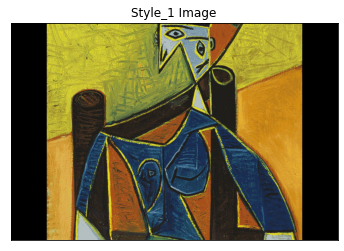

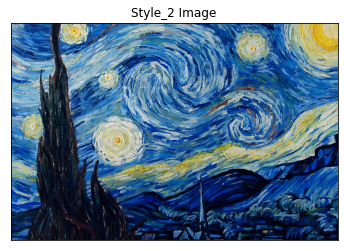

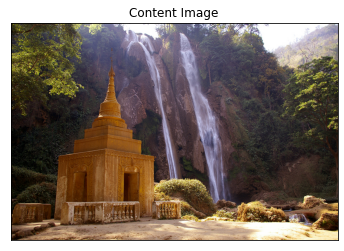

In [20]:
# Drawing function and applying of it
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0) 
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([]) # remove all labels of axis
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img1, title='Style_1 Image')
plt.figure()
imshow(style_img2, title='Style_2 Image')
plt.figure()
imshow(content_img, title='Content Image')

## Loss functions

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)
        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()

            self.target = target.detach() #remove computational tree
            self.loss = F.mse_loss(self.target, self.target )# to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [0]:
def gram_matrix(input):
        batch_size, f_map_num, h, w  = input.size()  # batch size, number of feature maps, h & w - dimensions of a feature map
        features = input.reshape(batch_size * f_map_num, h * w)  # resize tensor to achive right gram matrix in the future. 

        G = torch.mm(features, features.t())  # compute the gram product
        return G.div(batch_size * h * w * f_map_num) # normalizing by dividing on a number of elements

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [0]:
class StyleLoss_mix(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss_mix, self).__init__()
            target1 = gram_matrix(target_feature1).detach() # first gram matrix
            target2 = gram_matrix(target_feature2).detach() # second gram matrix
            self.target = (target1 + target2)/2 # mean of style gram matrices
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something
        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [0]:
class StyleLoss2(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss2, self).__init__()
            self.target1 = gram_matrix(target_feature1[:, :, :, :(len(target_feature1[0][0][0])//2)]).detach() # left gram matrix
            self.target2 = gram_matrix(target_feature2[:, :, :, (len(target_feature2[0][0][0])//2):]).detach() # right gram matrix
            self.loss = F.mse_loss(self.target1, self.target2)# to initialize with something

        def forward(self, input):
            G1 = gram_matrix(input[:, :, :, :(len(input[0][0][0])//2)]) # left gram matrix
            G2 = gram_matrix(input[:, :, :, (len(input[0][0][0])//2):]) # right gram matrix
            self.loss1 = F.mse_loss(G1, self.target1) # left loss
            self.loss2 = F.mse_loss(G2, self.target2) # right loss
            self.loss = (self.loss1+self.loss2)/2 # style loss
   
            return input

## Neural Network (based on VGG16 architecture)

In [14]:
cnn = models.vgg16(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
# Some experiments with amount of output losses
content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4','conv_5']

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                               style_img1, style_img2=None,
                               content_img=None,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, style='1'):
        
        # setting loss according to chosen style 
        if style == 'mix':
          stl = StyleLoss_mix
        elif style in ['mix2', '1']:
          stl = StyleLoss
        elif style == '2':
          stl = StyleLoss2
        
        content_losses = []
        style_losses = []

        # Construction of NN
        cnn = copy.deepcopy(cnn)
        normalization = Normalization(normalization_mean, normalization_std).to(device)
        model = nn.Sequential(normalization)

        i = 0  

        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False) # we have to change inplace to False
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:

                if style == 'mix':
                  target_feature1 = model(style_img1).detach()
                  target_feature2 = model(style_img2).detach()
                  style_loss = stl(target_feature1, target_feature2)
                elif style == 'mix2':
                  style_img = torch.cat((style_img1[:,:,:, :(len(style_img1[0][0][0])//2)], style_img2[:,:,:, (len(style_img2[0][0][0])//2):]), dim=3)
                  target_feature = model(style_img).detach()
                  style_loss = stl(target_feature)
                elif style == '2':
                  target_feature1 = model(style_img1).detach()
                  target_feature2 = model(style_img2).detach()
                  style_loss = stl(target_feature1, target_feature2)
                else:                  
                  target_feature = model(style_img1).detach()
                  style_loss = stl(target_feature)

                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], stl):
                break

        model = model[:(i + 1)]

        # print(model) # if want to see your model
        return model, style_losses, content_losses

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img1, style_img2=None, input_img=content_img.clone(), 
                       num_steps=1000,
                       style_weight=10**9, 
                       content_weight=1, style='1', lr=1):
  
        """Run the style transfer."""
        print('Building the style transfer model...')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img, style=style)
        
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=lr) # Optimizer

        run = [0]

        while run[0] <= num_steps:
            def closure():
                input_img.data.clamp_(0, 1)  # crop the values to [0,1]

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0
                
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                # weighten losses
                style_score *= style_weight
                content_score *= content_weight
                
                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    clear_output(wait=True)
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    plt.figure(figsize=(10,15))
                    imshow(input_img.data.clamp_(0, 1), title='Output Image')
                    plt.ioff()
                    plt.show()

                return style_score + content_score

            optimizer.step(closure)
            
        input_img.data.clamp_(0, 1)

        return input_img

## NST

run [1000]:
Style Loss : 309.077179 Content Loss: 8.297405


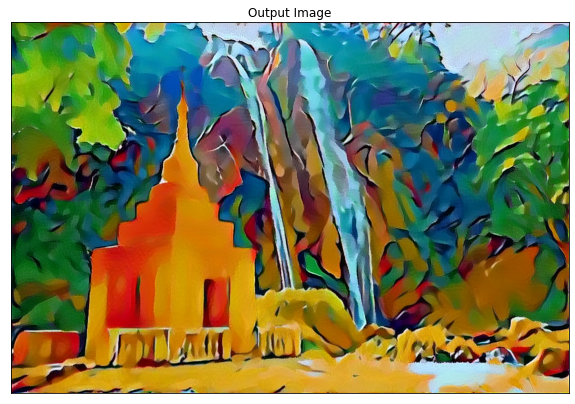

In [84]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device) # I have tried to use white noise, but had less interesting results
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, style='1', lr=0.05) # just one style

## NST Mix

run [1000]:
Style Loss : 46.266026 Content Loss: 7.901866


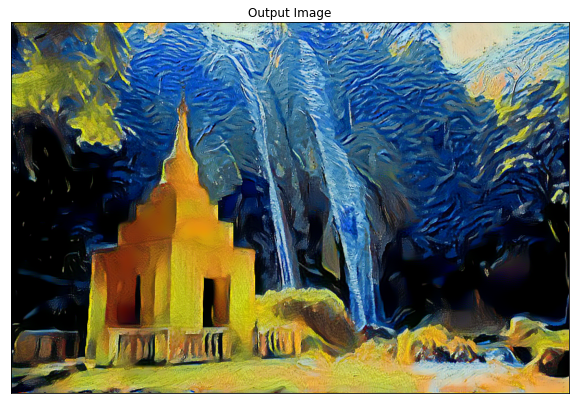

In [31]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device) # I have tried to use white noise, but had less interesting results
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, style='mix') # mix style

## NST Mix-2

run [1000]:
Style Loss : 110.113098 Content Loss: 9.242451


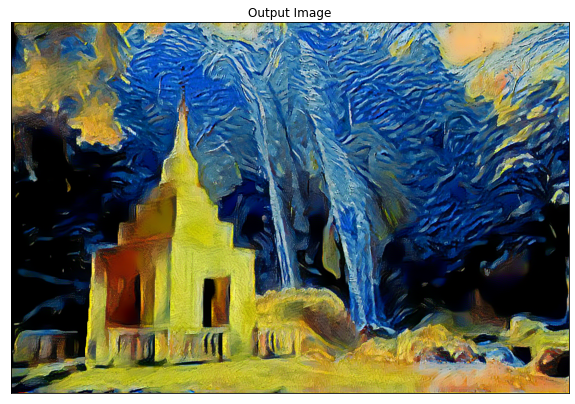

In [29]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device) # I have tried to use white noise, but had less interesting results
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, style='mix2') # mix-2 style

## NST 2 pics

run [1000]:
Style Loss : 21277.042969 Content Loss: 12.022820


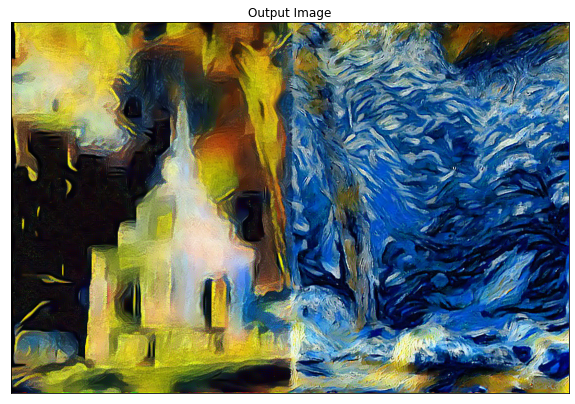

In [30]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device) # I have tried to use white noise, but had less interesting results
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, style='2')